## Consuming data using Kafka and Visualise (20%)
In this task, we will implement an Apache Kafka consumer to consume the data from Part 2.  
  
Important:   
-	In this part, Kafka consumers are used to consume the streaming data published from task 2.8.

In [1]:
# --- Cell 1: Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kafka3 import KafkaConsumer
import json
import time
import atexit
import threading
from collections import deque
from datetime import datetime, timedelta
import warnings

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, DecimalType, TimestampType, DateType, DoubleType
)
# Suppress harmless warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported successfully.")
# --- Cell 2: Enable Interactive Plotting ---
# Use 'ipympl' for a better interactive experience (requires 'pip install ipympl')
# Or use 'notebook' for the classic interactive backend.
%matplotlib ipympl
# %matplotlib notebook

# --- Cell 2: Start Spark Session ---
# This is required for Cell 4
spark = (
    SparkSession.builder
    .appName("A2B-Task3-Preprocessing")
    .master("local[4]")  # Use 4 cores, matching A2B-Task2
    .config("spark.sql.session.timeZone", "Australia/Melbourne")
    .getOrCreate()
)

print("SparkSession started.")
# --- Cell 3: Configuration ---
HOST_IP = "192.168.0.6"  # <<< SET YOUR KAFKA SERVER IP HERE
TOPIC_BUILDING = "building_6h"
TOPIC_SITE = "site_daily"
DATA_BUFFER_SIZE = 1000 # Hold up to 1000 data points per buffer

# File paths for Task 3.1
METERS_FILE = "data/new_meters.csv"
BUILDING_INFO_FILE = "data/new_building_information.csv"

print(f"Configuration set. Host: {HOST_IP}")


Libraries imported successfully.
SparkSession started.
Configuration set. Host: 192.168.0.6


In [2]:
# --- Cell 4: Task 3.1 - Load and Pre-process Actual Data (PySpark Version) ---

# Schemas you provided
meters_schema = StructType([
    StructField("building_id", IntegerType(), False),
    StructField("meter_type", StringType(), False),
    StructField("ts", TimestampType(), False),
    StructField("value", DecimalType(15, 4), False),
    StructField("row_id", IntegerType(), False)
])

buildings_schema = StructType([
    StructField("site_id", IntegerType(), False),
    StructField("building_id", IntegerType(), False),
    StructField("primary_use", StringType(), True),
    StructField("square_feet", IntegerType(), True),
    StructField("floor_count", IntegerType(), True),
    StructField("row_id", IntegerType(), False),
    StructField("year_built", IntegerType(), True),
    StructField("latent_y", DecimalType(6, 4), True),
    StructField("latent_s", DecimalType(6, 4), True),
    StructField("latent_r", DecimalType(6, 4), True)
])

def load_actual_data_pyspark(meters_file, building_file):
    """
    Loads and pre-processes actual meter and building data using PySpark.
    """
    try:
        # Load static datasets
        print(f"Loading {meters_file} with PySpark...")
        meters_df = spark.read.csv(
            meters_file,
            header=True,
            schema=meters_schema
        )

        print(f"Loading {building_file} with PySpark...")
        buildings_df = spark.read.csv(
            building_file,
            header=True,
            schema=buildings_schema
        )
        
        # --- Pre-process Meter Data ---
        # Convert 'ts' to date and filter
        meters_with_date = meters_df.withColumn("date", F.to_date("ts"))

        # Aggregate to get total power per building per day
        daily_building_actual = (
            meters_with_date.groupBy("building_id", "date")
            .agg(F.sum("value").alias("value"))
        )

        # --- Merge and Final Aggregation ---
        # Keep only necessary columns for merging
        building_site_map = buildings_df.select("building_id", "site_id").distinct()

        # Merge actual building data with site map
        daily_site_actual_merged = daily_building_actual.join(
            building_site_map,
            on="building_id"
        )

        # Aggregate by site_id and date
        actual_data_lookup_spark = (
            daily_site_actual_merged.groupBy("site_id", "date")
            .agg(F.sum("value").alias("value"))
        )
        
        # --- Bridge to Pandas for Plotting ---
        # Collect the results from Spark and convert to a Pandas DF
        # This is necessary for the existing plotting logic in Cell 7
        print("Aggregation complete. Collecting results to Pandas...")
        actual_data_lookup_df = actual_data_lookup_spark.toPandas()
        
        # Ensure date column is a date object (toPandas() should handle this)
        actual_data_lookup_df['date'] = pd.to_datetime(actual_data_lookup_df['date']).dt.date
        
        print("Successfully loaded and pre-processed actual data lookup.")
        return actual_data_lookup_df

    except Exception as e:
        print(f"An error occurred during PySpark data loading: {e}")
        return None

# Load the data
actual_data_lookup = load_actual_data_pyspark(METERS_FILE, BUILDING_INFO_FILE)
if actual_data_lookup is not None:
    print(f"Loaded {len(actual_data_lookup)} actual daily site records into Pandas.")

Loading data/new_meters.csv with PySpark...
Loading data/new_building_information.csv with PySpark...
Aggregation complete. Collecting results to Pandas...
Successfully loaded and pre-processed actual data lookup.
Loaded 5781 actual daily site records into Pandas.


In [3]:
# # Gemini v3 clean slate
# # --- Cell 4: Task 3.1 - Load and Pre-process Actual Data ---


# from pyspark.sql.types import (
#     StructType, StructField,
#     IntegerType, StringType, DecimalType, TimestampType, DateType, DoubleType
# )

# meters_schema = StructType([
#     StructField("building_id", IntegerType(), False),
#     StructField("meter_type", StringType(), False),   # Char(1) -> StringType
#     StructField("ts", TimestampType(), False),
#     StructField("value", DecimalType(15, 4), False),
#     StructField("row_id", IntegerType(), False)
# ])

# def load_actual_data(meters_file, building_file):
#     """
#     Loads and pre-processes actual meter and building data to create a
#     lookup table for daily energy consumption per site.
#     """
#     try:
        
#         # Load static datasets [cite: 45, 150]
#         print(f"Loading {meters_file}...")
#         meters_df = spark.read.csv(
#             "data/new_meters.csv",
#             header=True,
#             schema=meters_schema
#         )
        
#         print(f"Loading {building_file}...")
#         buildings_df = pd.read_csv(building_file)

#         # --- Pre-process Meter Data ---
#         # Convert 'ts' to datetime objects and extract date [cite: 231]
#         meters_df.withColumn("date", F.to_date("timestamp"))
# #         meters_df['ts'] = pd.to_datetime(meters_df['ts'])
# #         meters_df['date'] = meters_df['ts'].dt.date
        
#         # Aggregate to get total power per building per day
#         # This sums up all meter types ('e', 'c', 's', 'h') for each building [cite: 231]
#         daily_building_actual = meters_df.groupby(['building_id', 'date'])['value'].sum().reset_index()

#         # --- Pre-process Building Data ---
#         # Ensure correct column names (Metadata has 'site id' with a space) [cite: 234]
#         if 'site id' in buildings_df.columns:
#             buildings_df = buildings_df.rename(columns={'site id': 'site_id'})
        
#         # Keep only necessary columns for merging
#         building_site_map = buildings_df[['building_id', 'site_id']]

#         # --- Merge and Final Aggregation ---
#         # Merge actual building data with site map
#         daily_site_actual_merged = daily_building_actual.merge(building_site_map, on='building_id')
        
#         # Aggregate by site_id and date to get the final "actual" value
#         actual_data_lookup_df = daily_site_actual_merged.groupby(['site_id', 'date'])['value'].sum().reset_index()
        
#         # Ensure date column is a date object for proper comparison
#         actual_data_lookup_df['date'] = pd.to_datetime(actual_data_lookup_df['date']).dt.date
        
#         print("Successfully loaded and pre-processed actual data lookup.")
#         return actual_data_lookup_df

#     except FileNotFoundError as e:
#         print(f"Error: {e}. Make sure '{METERS_FILE}' and '{BUILDING_INFO_FILE}' are in the same directory.")
#         return None
#     except Exception as e:
#         print(f"An error occurred during data loading: {e}")
#         return None

# # Load the data
# actual_data_lookup = load_actual_data(METERS_FILE, BUILDING_INFO_FILE)
# if actual_data_lookup is not None:
#     print(f"Loaded {len(actual_data_lookup)} actual daily site records.")
    

In [4]:
# --- Cell 5: Global State and Thread Management ---

# Thread-safe data buffers
# INCREASED MAXLEN: 1000 is too small for the stream's throughput.
DATA_BUFFER_SIZE = 50000 
building_data_buffer = deque(maxlen=DATA_BUFFER_SIZE)
site_data_buffer = deque(maxlen=DATA_BUFFER_SIZE)

# Shared state variables
latest_date_received = None 
data_lock = threading.Lock() 
stop_event = threading.Event() 
consumer_threads = []
consumers_list = [] 

# Track the last date we plotted
last_plotted_date = None

print(f"Global state variables initialized. Buffer size: {DATA_BUFFER_SIZE}")

# --- Cell 6: Kafka Consumer Thread Function ---

def connect_kafka_consumer(topic):
    """Connects to Kafka, retrying a few times."""
    consumer = None
    for i in range(3): # Retry connection
        try:
            consumer = KafkaConsumer(
                topic,
                bootstrap_servers=[f'{HOST_IP}:9092'],
                auto_offset_reset='latest', # Start from new messages
                value_deserializer=lambda x: x.decode('utf-8'),
                # Use a unique group_id to ensure we get new data
                group_id=f'task3-{topic}-{datetime.now().timestamp()}',
                enable_auto_commit=True,
                consumer_timeout_ms=5000 # Timeout to check stop_event
            )
            consumers_list.append(consumer) # Register for cleanup
            print(f"[{topic}] Consumer connected successfully.")
            return consumer
        except Exception as e:
            print(f"[{topic}] Connection attempt {i+1} failed: {e}")
            time.sleep(2)
    return None

def kafka_consumer_thread(topic, buffer_deque):
    """
    Thread function to consume from a Kafka topic and fill a shared buffer.
    """
    global latest_date_received
    
    consumer = connect_kafka_consumer(topic)
    if not consumer:
        print(f"[{topic}] Thread exiting due to connection failure.")
        return

    print(f"[{topic}] Listening for messages...")
    try:
        while not stop_event.is_set():
            try:
                # Poll for messages with a timeout
                for message in consumer:
                    if stop_event.is_set():
                        break
                        
                    # 1. Deserialize JSON
                    data = json.loads(message.value)
                    
                    # 2. Parse date string to a date object
                    current_date = datetime.strptime(data['date'], '%Y-%m-%d').date()
                    data['date_obj'] = current_date # Store the object for easy filtering
                    
                    # 3. Acquire lock to update shared state
                    with data_lock:
                        buffer_deque.append(data)
                        
                        # Update the latest date seen across *all* streams
                        if latest_date_received is None or current_date > latest_date_received:
                            latest_date_received = current_date
                            
            except StopIteration:
                # This happens when consumer_timeout_ms is reached
                # It's our chance to check the stop_event
                continue
            except json.JSONDecodeError as e:
                print(f"[{topic}] JSON Decode Error: {e} - Skipping message: {message.value}")
            except Exception as e:
                print(f"[{topic}] Error in consumer loop: {e}")
                # Brief pause to prevent rapid-fire errors
                time.sleep(1)

    except Exception as e:
        print(f"[{topic}] Consumer thread unhandled exception: {e}")
    finally:
        print(f"[{topic}] Thread shutting down...")
        consumer.close()

print("Consumer thread function defined.")

Global state variables initialized. Buffer size: 50000
Consumer thread function defined.


Plotting functions defined. Figure created.


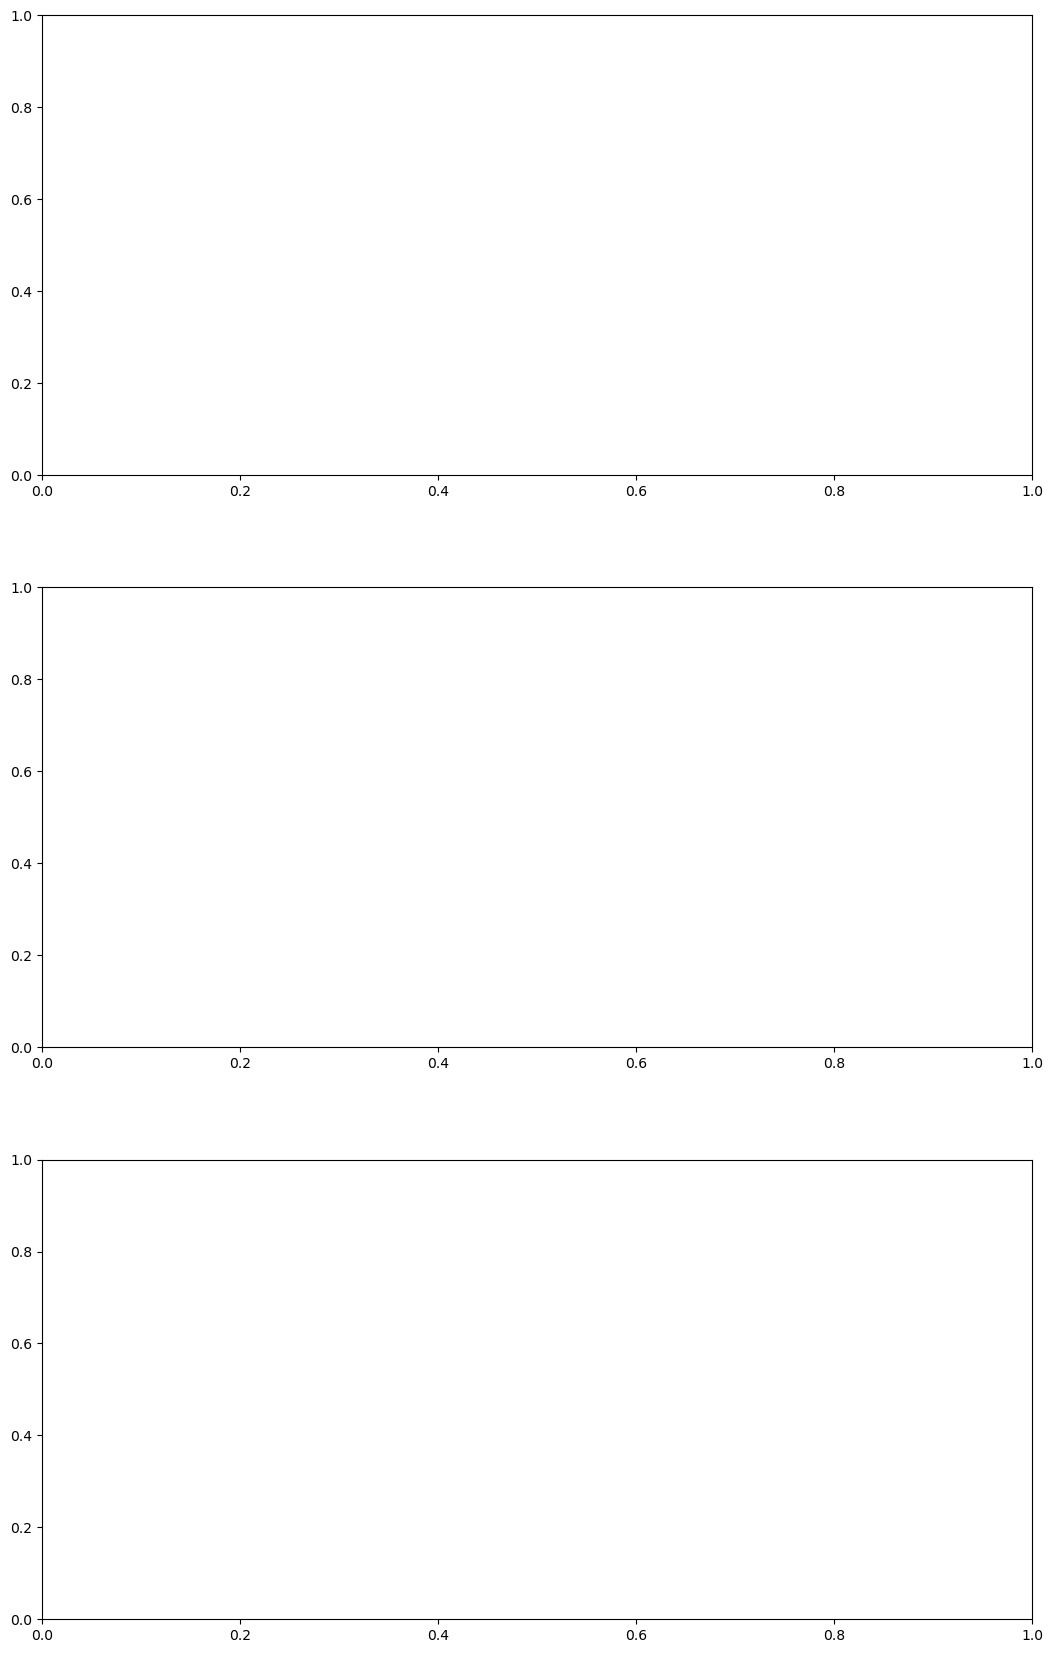

Starting consumer threads...
Main plotting loop starting... Press 'Interrupt Kernel' to stop.
[building_6h] Consumer connected successfully.
[building_6h] Listening for messages...
[site_daily] Consumer connected successfully.
[site_daily] Listening for messages...


In [ ]:
# # --- Cell 7: Plotting Setup and Functions (Tasks 3.2 & 3.3) ---

# # Set up the figure and subplots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
# fig.tight_layout(pad=6.0) # Add padding for titles

# def update_plots(plot_date, bldg_data, site_data):
#     """
#     Clears and redraws all three plots for the specified date.
#     """
#     # --- ADDED DEBUGGING ---
#     print(f"--- Plotting data for date: {plot_date} ---")
#     print(f"    Received {len(bldg_data)} building records.")
#     print(f"    Received {len(site_data)} site records.")
#     # --- END DEBUGGING ---
    
#     # --- Clear all axes ---
#     ax1.clear()
#     ax2.clear()
#     ax3.clear()
    
#     # Update main title with the date being plotted
#     fig.suptitle(f"Energy Consumption Dashboard - Showing Data for: {plot_date}", fontsize=16)

#     # === Plot 1 (Task 3.2a - Building 6h) ===
#     if not bldg_data:
#         ax1.set_title("Predicted Power Distribution (All Buildings) per 6h Interval")
#         ax1.text(0.5, 0.5, "No building data to plot", horizontalalignment='center', transform=ax1.transAxes)
#     else:
#         bldg_df = pd.DataFrame(bldg_data)
#         time_buckets = ['0-6h', '6-12h', '12-18h', '18-24h']
#         bldg_df['time'] = pd.Categorical(bldg_df['time'], categories=time_buckets, ordered=True)
        
#         sns.boxplot(x='time', y='total_power_6h', data=bldg_df, ax=ax1, order=time_buckets)
        
#         ax1.set_title("Predicted Power Distribution (All Buildings) per 6h Interval")
#         ax1.set_xlabel("Time Bucket")
#         ax1.set_ylabel("Predicted Power (total_power_6h)")
#         ax1.grid(axis='y', linestyle='--', alpha=0.7)

#     # === Plot 2 (Task 3.2b - Site Daily) ===
#     if not site_data:
#         ax2.set_title("Predicted Daily Total Power per Site")
#         ax2.text(0.5, 0.5, "No site data to plot", horizontalalignment='center', transform=ax2.transAxes)
#     else:
#         site_df = pd.DataFrame(site_data).sort_values('site_id')
        
#         ax2.bar(site_df['site_id'], site_df['total_power_day'], color='tab:blue')
        
#         ax2.set_title("Predicted Daily Total Power per Site")
#         ax2.set_xlabel("Site ID")
#         ax2.set_ylabel("Predicted Power (total_power_day)")
#         ax2.set_xticks(range(16)) 
#         ax2.grid(axis='y', linestyle='--', alpha=0.7)

#     # === Plot 3 (Task 3.3 - Shortfall/Excess) ===
#     if not site_data or actual_data_lookup is None:
#         ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
#         ax3.text(0.5, 0.5, "No predicted or actual data to plot", horizontalalignment='center', transform=ax3.transAxes)
#     else:
#         pred_df = pd.DataFrame(site_data)
#         actual_df = actual_data_lookup[actual_data_lookup['date'] == plot_date]
        
#         if actual_df.empty:
#             ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
#             ax3.text(0.5, 0.5, f"No *actual* data found for {plot_date}", horizontalalignment='center', transform=ax3.transAxes)
#         else:
#             merged_df = pred_df.merge(actual_df, on='site_id', suffixes=('_pred', '_actual'))
#             # --- FIX: Cast both columns to float for subtraction ---
#             merged_df['total_power_day'] = merged_df['total_power_day'].astype(float)
#             merged_df['value'] = merged_df['value'].astype(float)
#             # --- END FIX ---
#             merged_df['shortfall'] = merged_df['total_power_day'] - merged_df['value']
            
#             colors = merged_df['shortfall'].apply(lambda x: 'red' if x > 0 else 'green')
#             ax3.bar(merged_df['site_id'], merged_df['shortfall'], color=colors)
#             ax3.axhline(0, color='black', linestyle='--') 
            
#             ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
#             ax3.set_xlabel("Site ID")
#             ax3.set_ylabel("Shortfall (Predicted - Actual)")
#             ax3.legend([
#                 plt.Rectangle((0,0),1,1, color='red'),
#                 plt.Rectangle((0,0),1,1, color='green')
#             ], ['Shortfall (Over-predicted)', 'Excess (Under-predicted)'])
#             ax3.set_xticks(range(16))
#             ax3.grid(axis='y', linestyle='--', alpha=0.7)

#     # --- Redraw the canvas ---
#     fig.canvas.draw()
    
#     # --- ADDED RENDER FAILSAFE ---
#     # Force the interactive backend to flush the draw events
#     fig.canvas.flush_events() 
#     # --- END FAILSAFE ---
    
#     print(f"--- Plot update for {plot_date} complete ---")


# print("Plotting functions defined. Figure created.")
# # Display the figure object once
# display(fig)

# --- Cell 7: Plotting Setup and Functions (Tasks 3.2 & 3.3) ---

# Set up the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.tight_layout(pad=6.0) # Add padding for titles

def update_plots(plot_date, bldg_data, site_data):
    """
    Clears and redraws all three plots for the specified date.
    """
    print(f"--- Plotting data for date: {plot_date} ---")
    print(f"    Received {len(bldg_data)} building records.")
    print(f"    Received {len(site_data)} site records.")
    
    # --- Clear all axes ---
    ax1.clear()
    ax2.clear()
    ax3.clear()
    
    # Update main title
    fig.suptitle(f"Energy Consumption Dashboard - Showing Data for: {plot_date}", fontsize=16)

    # === Plot 1 (Task 3.2a - Building 6h) ===
    if not bldg_data:
        ax1.set_title("Predicted Power Distribution (All Buildings) per 6h Interval")
        ax1.text(0.5, 0.5, "No building data to plot", horizontalalignment='center', transform=ax1.transAxes)
    else:
        bldg_df = pd.DataFrame(bldg_data)
        # (This plot was fine, no changes needed)
        time_buckets = ['0-6h', '6-12h', '12-18h', '18-24h']
        bldg_df['time'] = pd.Categorical(bldg_df['time'], categories=time_buckets, ordered=True)
        
        sns.boxplot(x='time', y='total_power_6h', data=bldg_df, ax=ax1, order=time_buckets)
        
        ax1.set_title("Predicted Power Distribution (All Buildings) per 6h Interval")
        ax1.set_xlabel("Time Bucket")
        ax1.set_ylabel("Predicted Power (total_power_6h)")
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # === Plot 2 (Task 3.2b - Site Daily) ===
    if not site_data:
        ax2.set_title("Predicted Daily Total Power per Site")
        ax2.text(0.5, 0.5, "No site data to plot", horizontalalignment='center', transform=ax2.transAxes)
    else:
        site_df_raw = pd.DataFrame(site_data)
        
        # --- FIX: Aggregate the data by site_id before plotting ---
        site_df = site_df_raw.groupby('site_id')['total_power_day'].sum().reset_index()
        # --- END FIX ---
        
        ax2.bar(site_df['site_id'], site_df['total_power_day'], color='tab:blue')
        
        ax2.set_title("Predicted Daily Total Power per Site")
        ax2.set_xlabel("Site ID")
        ax2.set_ylabel("Predicted Power (total_power_day)")
        ax2.set_xticks(range(16)) 
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # === Plot 3 (Task 3.3 - Shortfall/Excess) ===
    if not site_data or actual_data_lookup is None:
        ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
        ax3.text(0.5, 0.5, "No predicted or actual data to plot", horizontalalignment='center', transform=ax3.transAxes)
    else:
        pred_df_raw = pd.DataFrame(site_data)
        
        # --- FIX: Aggregate the predicted data by site_id before merging ---
        pred_df = pred_df_raw.groupby('site_id')['total_power_day'].sum().reset_index()
        # --- END FIX ---
        
        actual_df = actual_data_lookup[actual_data_lookup['date'] == plot_date]

        if actual_df.empty:
            ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
            ax3.text(0.5, 0.5, f"No *actual* data found for {plot_date}", horizontalalignment='center', transform=ax3.transAxes)
        else:
            merged_df = pred_df.merge(actual_df, on='site_id', suffixes=('_pred', '_actual'))
            
            # Cast both columns to float
            merged_df['total_power_day'] = merged_df['total_power_day'].astype(float)
            merged_df['value'] = merged_df['value'].astype(float)

            merged_df['shortfall'] = merged_df['total_power_day'] - merged_df['value']
            
            colors = merged_df['shortfall'].apply(lambda x: 'red' if x > 0 else 'green')
            ax3.bar(merged_df['site_id'], merged_df['shortfall'], color=colors)
            ax3.axhline(0, color='black', linestyle='--') 
            
            ax3.set_title("Predicted vs. Actual Power (Shortfall/Excess)")
            ax3.set_xlabel("Site ID")
            ax3.set_ylabel("Shortfall (Predicted - Actual)")
            ax3.legend([
                plt.Rectangle((0,0),1,1, color='red'),
                plt.Rectangle((0,0),1,1, color='green')
            ], ['Shortfall (Over-predicted)', 'Excess (Under-predicted)'])
            ax3.set_xticks(range(16))
            ax3.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Redraw the canvas ---
    fig.canvas.draw()
    fig.canvas.flush_events() 
    
    # Force matplotlib's event loop to render
    plt.pause(0.1)
    
    print(f"--- Plot update for {plot_date} complete ---")


print("Plotting functions defined. Figure created.")
# # Display the figure object once
display(fig)


# --- Cell 8: Main Application Loop (Start Threads and Plot) ---

def main_plot_loop():
    """
    Main loop to check for new data and trigger plots.
    Runs in the main thread.
    """
    global last_plotted_date
    
    print("Main plotting loop starting... Press 'Interrupt Kernel' to stop.")
    while not stop_event.is_set():
        try:
            current_latest_date = None
            plot_date = None
            
            # --- Check for new date to plot ---
            with data_lock:
                if latest_date_received:
                    current_latest_date = latest_date_received
            
            if current_latest_date:
                # YOUR LOGIC: Plot data for day X when data for day X+2 arrives
                plot_date = current_latest_date - timedelta(days=2)
            
            # --- Check if we already plotted this date ---
            if plot_date and plot_date != last_plotted_date:
                
                # --- Get data for the plot_date ---
                # We must do this in a thread-safe way
                with data_lock:
                    # Filter the buffers for the specific date
                    # This copies the data, so we can release the lock
                    building_data_to_plot = [
                        d for d in building_data_buffer 
                        if d['date_obj'] == plot_date
                    ]
                    site_data_to_plot = [
                        d for d in site_data_buffer 
                        if d['date_obj'] == plot_date
                    ]
                
                # --- Check if data is present ---
                if not building_data_to_plot and not site_data_to_plot:
                    # We saw day X+2, but we don't have data for day X
                    # This might happen if data is sparse.
                    # We'll mark it as "plotted" to avoid checking again.
                    print(f"No data found for {plot_date}, skipping.")
                    last_plotted_date = plot_date # Mark as done
                else:
                    # --- We have a new date and new data! ---
                    # Call update_plots (which is thread-safe)
                    update_plots(plot_date, building_data_to_plot, site_data_to_plot)
                    last_plotted_date = plot_date # Mark as done
            
            # Sleep to yield control and not busy-wait
            time.sleep(1) # Check for new data every second
            
        except KeyboardInterrupt:
            print("\nKeyboardInterrupt received. Shutting down...")
            break
        except Exception as e:
            print(f"Error in main_plot_loop: {e}")
            break
    
    print("Main plotting loop finished.")

# --- Cleanup function to run at script exit ---
def cleanup_all():
    """Signals all threads to stop and closes consumers."""
    print("\n--- Initiating shutdown ---")
    if not stop_event.is_set():
        stop_event.set()
        
        print("Waiting for consumer threads to join...")
        for t in consumer_threads:
            t.join(timeout=2) # Wait max 2s for thread
        
        print("Closing Kafka consumers...")
        for c in consumers_list:
            try:
                c.close()
            except Exception as e:
                print(f"Error closing consumer: {e}")
        
        plt.close(fig) # Close the plot window
        print("--- Cleanup complete ---")

# Register the cleanup function
atexit.register(cleanup_all)

# --- Start the application ---
if actual_data_lookup is not None:
    try:
        # Start consumer threads
        thread_bldg = threading.Thread(
            target=kafka_consumer_thread, 
            args=(TOPIC_BUILDING, building_data_buffer), 
            daemon=True
        )
        thread_site = threading.Thread(
            target=kafka_consumer_thread, 
            args=(TOPIC_SITE, site_data_buffer), 
            daemon=True
        )
        
        consumer_threads.extend([thread_bldg, thread_site])
        
        print("Starting consumer threads...")
        thread_bldg.start()
        thread_site.start()
        
        # Run the plotting loop in the main thread
        main_plot_loop()
        
    except Exception as e:
        print(f"An error occurred during startup: {e}")
    finally:
        # Ensure cleanup runs if the loop exits unexpectedly
        cleanup_all()
else:
    print("Application cannot start because actual data failed to load.")

print("Application has stopped.")



1.	Load the new meters CSV file into a data frame.

In [ ]:
# from pyspark.sql.types import (
#     StructType, StructField,
#     IntegerType, StringType, DecimalType, TimestampType, DateType, DoubleType
# )
# # 1. Meters Table
# meters_schema = StructType([
#     StructField("building_id", IntegerType(), False),
#     StructField("meter_type", StringType(), False),   # Char(1) -> StringType
#     StructField("ts", TimestampType(), False),
#     StructField("value", DecimalType(15, 4), False),
#     StructField("row_id", IntegerType(), False)
# ])

# new_meters_df = spark.read.csv(
#     "data/new_meters.csv",
#     header=True,
#     schema=meters_schema
# )

2.	Plot two diagrams to show data from 6b and 6c. You are free to choose the type of plot.

3.	Plot a diagram to visualise the daily shortfall/excess energy in each site. The shortfall/excess energy is defined as the predicted total sum of energy in each site, minus the metered data (the value can be positive or negative, depending on the model and data quality).